# **Lunar Lander DQN Simulation**

This simulation utilizes Deep Q-Network (DQN) to train an agent to land a spacecraft on the lunar surface. The DQN is a type of artificial intelligence model that combines deep neural networks and Q-learning, a type of reinforcement learning, to optimize decision-making processes in environments with discrete actions.

## **Overview**

The simulation uses the `LunarLander-v2` environment from the `gym` library, a toolkit for developing and comparing reinforcement learning algorithms. The aim is to guide a lunar lander to a safe landing on a landing pad. The environment provides a state containing positional and velocity information about the lander and returns rewards based on the lander's actions. The DQN agent learns from these rewards to improve its landing strategy over time.

The user interface for the simulation is created using the `pygame` library, providing a visual representation of the lunar lander's position, angle, and landing success rate.

## **Key Components**

1. **Environment Initialization:** The `LunarLander-v2` environment from `gym` is initialized, providing the framework for the DQN agent's interactions.
  
2. **Neural Network Model:** The DQN consists of a neural network model, implemented using `tensorflow` and `keras`. This model takes in the state of the lunar lander and outputs the best action to take.

3. **Experience Replay:** As the agent interacts with the environment, it stores its experiences in a memory buffer. Periodically, the agent samples from this buffer to train its neural network, improving its decision-making abilities.

4. **Exploration vs. Exploitation:** The agent employs an epsilon-greedy strategy, where it occasionally takes a random action (exploration) but predominantly chooses the action recommended by its neural network (exploitation). Over time, the agent reduces its exploration rate.

5. **Visual Simulation with Pygame:** The position, angle, and landing success rate of the lunar lander are visualized using the `pygame` library. This provides an interactive display, allowing users to watch the agent's progress in real-time.

---

## **Getting Started:**

**Install the required packages**

These packages facilitate various functionalities, ranging from the reinforcement learning environment, deep learning model creation, to the interactive visualization:

- **Gym**  # Reinforcement learning environment
- **Pygame**   # Game development and visualization
- **Numpy**  # Numerical computations
- **Tensorflow**  # Deep learning framework
- **Keras**  # High-level neural networks API
- **matplotlib** # Used to create a display graphs

In [121]:
# Install the required packages
## -- pip install gym box2d-py tensorflow pygame -- ##
import gym
import pygame
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import logging
import os
from collections import deque
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers.legacy import Adam

**Pygame Setup and Display Configuration**

This section initializes the Pygame library, which is essential for creating interactive games and simulations. It then defines the display settings, setting the screen's width and height to 600x400 pixels. A window is created using these dimensions, and it's titled "Lunar Lander DQN Simulation." For visualization, background and rocket images are loaded and resized to fit appropriately on the screen. Lastly, standard colors (WHITE and GREEN) and a font for displaying iteration numbers are defined for further use in the simulation's user interface.

In [122]:
pygame.init()

# Display settings
SCREEN_WIDTH = 600
SCREEN_HEIGHT = 400
screen = pygame.display.set_mode((SCREEN_WIDTH, SCREEN_HEIGHT))
pygame.display.set_caption("Lunar Lander DQN Simulation")

# Load and resize images
background_image = pygame.transform.scale(pygame.image.load("moon.png"), (SCREEN_WIDTH, SCREEN_HEIGHT))
rocket_image = pygame.transform.scale(pygame.image.load("rocket.png"), (150, 150))

# Define colors and fonts
WHITE = (255, 255, 255)
GREEN = (0, 255, 0)
iteration_font = pygame.font.Font(None, 24)

**User Interface Rendering for Lunar Lander Simulation**

This set of functions is dedicated to rendering the visual components of the Lunar Lander DQN Simulation. The `draw_lander` function takes the x and y coordinates, along with the angle of the rocket, to draw a rotated rocket image on the screen. In contrast, the `draw_ui_text` function displays the current episode number and the success rate of landings to keep the user informed about the simulation's progress. The `draw_landing_pad` function visualizes the landing pad; its color indicates whether the landing is successful (GREEN) or not (WHITE). Finally, the `draw_lunar_ui` function integrates all these components to create the complete user interface for the simulation, showcasing the lander, the landing pad, the episode information, and the success rate on a lunar background.

In [123]:
def draw_lander(x, y, angle):
    """Draw the rocket on the screen with a given position and angle."""
    screen_x = int((x + 1) * SCREEN_WIDTH / 2)
    screen_y = int(SCREEN_HEIGHT - y * SCREEN_HEIGHT / 2)
    rotated_rocket = pygame.transform.rotate(rocket_image, -np.degrees(angle))
    rocket_rect = rotated_rocket.get_rect(center=(screen_x, screen_y))
    screen.blit(rotated_rocket, rocket_rect.topleft)

def draw_ui_text(episodeIndex, success_percentage):
    """Draw episode and success rate text on the screen."""
    episode_text = iteration_font.render(f"Episode: {episodeIndex+1}", True, WHITE)
    success_text = iteration_font.render(f"Success Rate: {success_percentage:.2f}%", True, WHITE)
    screen.blit(episode_text, (int(SCREEN_WIDTH * 0.07), int(SCREEN_HEIGHT * 0.9)))
    screen.blit(success_text, (int(SCREEN_WIDTH * 0.7), int(SCREEN_HEIGHT * 0.9)))

def draw_landing_pad(successful_landing):
    """Draw the landing pad on the screen."""
    pad_width = 100
    pad_height = 15
    pad_x = (SCREEN_WIDTH - pad_width) // 2
    pad_y = SCREEN_HEIGHT - pad_height
    color = GREEN if successful_landing else WHITE
    pygame.draw.rect(screen, color, (pad_x, pad_y, pad_width, pad_height))

def draw_lunar_ui(x, y, angle, episodeIndex, success_percentage, successful_landing):
    """Draw the entire user interface for the lunar lander simulation."""
    screen.blit(background_image, (0, 0))
    draw_lander(x, y, angle)
    draw_ui_text(episodeIndex, success_percentage)
    draw_landing_pad(successful_landing)
    pygame.display.flip()

**Deep Q-Network (DQN) for Lunar Lander Training**

The `DQN` class is designed to implement the Deep Q-Network algorithm, a type of reinforcement learning, specifically tailored for training a lunar lander agent. The class contains several key components:

- **Initialization (`__init__`)**: Upon instantiation, the class initializes the environment, defines the state and action sizes, and sets various parameters such as the memory buffer size (`memory`), discount factor (`gamma`), exploration rate (`epsilon`), and learning rate (`learning_rate`). It also constructs two neural network models: the primary model (`model`) and the target model (`target_model`).

- **Neural Network Model (`_build_model`)**: This method establishes the architecture of the neural network model. It consists of two hidden layers with 24 neurons each and uses the ReLU activation function. The output layer corresponds to the possible actions, and the model is compiled with Mean Squared Error (MSE) as the loss function and the Adam optimizer.

- **Update Target Model (`update_target_model`)**: Ensures that the target model's weights are synchronized with the main model's weights, which is vital for stability in learning.

- **Storing Experience (`remember`)**: This function allows the agent to store experiences, which are tuples of state, action, reward, next state, and a 'done' flag, into its memory. This memory is then used for training.

- **Action Selection (`act`)**: Determines the agent's action. It either exploits the current knowledge (choosing the best action based on the model's predictions) or explores a new action (chooses randomly) based on the exploration rate (`epsilon`).

- **Training from Memory (`replay`)**: This method trains the neural network model using randomly sampled experiences from memory. It updates the Q-values based on the reward and the highest Q-value of the next state, using the target model for predictions.

- **Loading and Saving Models (`load` and `save`)**: These methods enable the user to load pre-trained weights into the model or save the current model's weights for future use.

Overall, he `DQN` class provides the machinery for an agent to learn optimal strategies for landing the lunar module through trial and error, leveraging neural networks to approximate the best actions given different states.

In [124]:
class DQN:
    """Deep Q-Network implementation for training the lunar lander."""
    
    def __init__(self, env):
        self.env = env
        self.state_size = env.observation_space.shape[0]
        self.action_size = env.action_space.n
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95  # discount factor
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()
        self.target_model = self._build_model()
        self.update_target_model()
    
    def _build_model(self):
        """Build the neural network model for the DQN."""
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        return model
    
    def update_target_model(self):
        """Update the target model with weights from the main model."""
        self.target_model.set_weights(self.model.get_weights())

    def remember(self, state, action, reward, next_state, done):
        """Store the experience in memory."""
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        """Select an action using the DQN or a random action."""
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])
    
    def replay(self, batch_size):
        """Train the DQN using experiences from the memory."""
        minibatch = random.sample(self.memory, batch_size)
        states = np.array([experience[0][0] for experience in minibatch])
        next_states = np.array([experience[3][0] for experience in minibatch])
        targets = self.model.predict(states)
        next_state_targets = self.target_model.predict(next_states)
        
        for i, (state, action, reward, next_state, done) in enumerate(minibatch):
            if done:
                targets[i][action] = reward
            else:
                targets[i][action] = reward + self.gamma * np.amax(next_state_targets[i])
                
        self.model.fit(states, targets, epochs=1, verbose=0)
        
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)

**Setting Up the Environment and Agent Initialization**

In this segment, the Lunar Lander environment is initialized using the `gym` library, which provides a standardized interface for reinforcement learning tasks. An instance of the DQN agent is then created, taking this environment as an argument, allowing it to interact and learn from it. Additionally, a batch size of 32 is specified for experience replay, indicating that 32 experiences will be randomly sampled from memory for each training iteration. The simulation is set to run for 1,000 episodes, and a counter (`successful_landings`) is initialized to zero to keep track of the number of times the agent successfully lands the lunar lander during these episodes.

In [125]:
env = gym.make('LunarLander-v2')
agent = DQN(env)
batch_size = 32
num_episodes = 1000
successful_landings = 0

## Graph

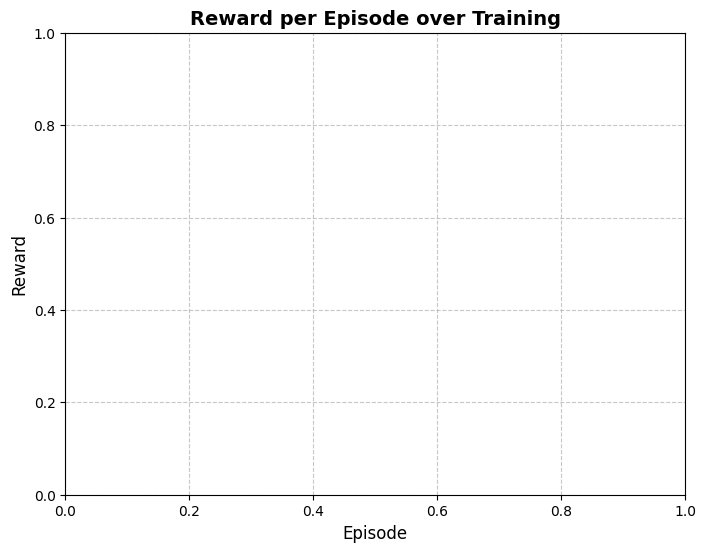

In [126]:
# Placeholder for collecting metrics
rewards_per_episode = []
# Turn on interactive mode for real-time updates
plt.ion()

# Initialize a figure for plotting
plt.figure(figsize=(8, 6))
plt.xlabel('Episode', fontsize=12)
plt.ylabel('Reward', fontsize=12)
plt.title('Reward per Episode over Training', fontsize=14, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.7)

**Training Loop for Lunar Lander Using Deep Q-Network (DQN)**

The provided code outlines the training loop used to teach the lunar lander agent using a Deep Q-Network (DQN). Each iteration of the outer loop represents a single episode of training, and within each episode, the agent interacts with its environment for a set number of time steps.

At the beginning of each episode, some initializations are made. The cumulative reward (`total_reward`) for the episode is set to zero, and the environment is reset to its initial state, providing the agent with a fresh start. This initial state is then reshaped to fit the DQN model's expected input format.

The inner loop represents the agent's interactions with the environment for each time step of the episode, capped at 500 iterations. Within this loop, the agent's current state, such as its position (`x`, `y`) and angle (`angle`), is used to render the visual interface, giving real-time feedback on its performance. Based on its current state, the agent then decides on an action, either exploiting its current knowledge or exploring a new action. This action is taken in the environment, which returns the resulting new state, the reward for the action, and a flag (`done`) indicating if the episode has ended (e.g., if the lander has crashed or landed successfully).

The agent's experience, consisting of its current state, chosen action, received reward, new state, and the `done` flag, is stored in its memory. This memory is used later for training the DQN. If the episode ends before the maximum number of time steps, the agent checks the total accumulated reward. If it surpasses a threshold (in this case, 50), it's deemed a successful landing, and the count of successful landings is incremented. Additionally, the DQN's target model is updated.

Every 10 episodes, the DQN model is trained using a batch of experiences randomly sampled from the agent's memory, refining its understanding of beneficial actions in different states.

Finally, after each episode, there's a brief pause before the next episode starts, allowing for better visualization of the agent's performance.

Throughout the training process, there are checks for user-initiated exit requests, ensuring the program can be gracefully terminated at any point.

1/1 [==============================] - 0s 12ms/step


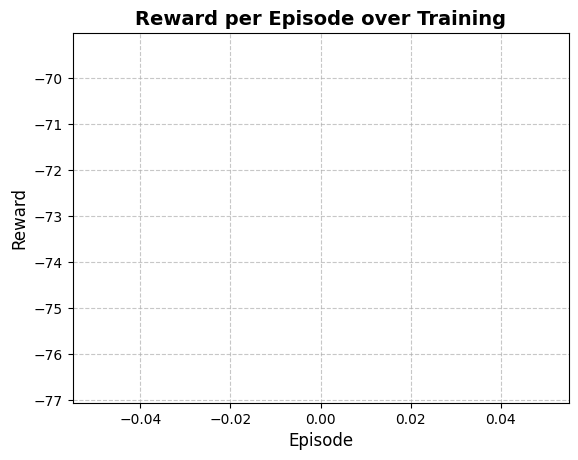

1/1 [==============================] - 0s 9ms/step


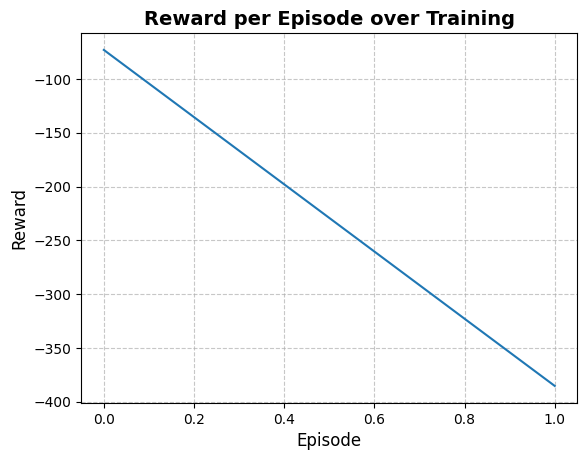

1/1 [==============================] - 0s 10ms/step


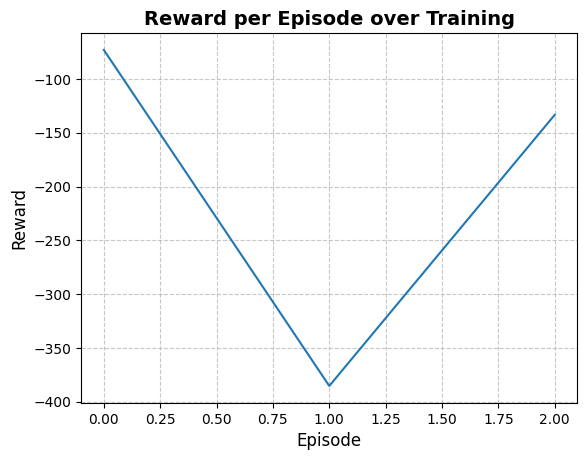

KeyboardInterrupt: 

In [127]:
# Loop over all episodes for training
for e in range(num_episodes):
    # Initialize the reward for this episode
    total_reward = 0
    # Flag to check if the landing was successful in this episode
    successful_landing = False
    # Reset the environment for a new episode and get initial state
    state, _ = env.reset()
    # Reshape the state to match the expected input shape for the DQN model
    state = np.reshape(state, [1, agent.state_size])
    
    # Loop for each time step in the episode
    for time in range(500):
        # Extract position and angle information from the state
        x = state[0][0]
        y = state[0][1]
        angle = state[0][4]
        # Calculate the success percentage so far
        success_percentage = (successful_landings / (e + 1)) * 100
        # Draw the UI with current state information
        draw_lunar_ui(x, y, angle, e, success_percentage, successful_landing)
        # Get an action from the DQN agent
        action = agent.act(state)
        # Perform the action in the environment
        next_state, reward, done, _, _ = env.step(action)
        # Accumulate the reward
        total_reward += reward
        # Modify the reward if the episode is done
        reward = reward if not done else -10
        # Reshape the next state to match the expected input shape for the DQN model
        next_state = np.reshape(next_state, [1, agent.state_size])
        # Store this experience in the agent's memory
        agent.remember(state, action, reward, next_state, done)
        # Set the current state for the next iteration
        state = next_state

        # Check for user exit request
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                pygame.quit()
                exit()

        # Check if episode is done
        if done:
            # If the total reward is above a threshold, consider it a successful landing
            if total_reward > 50:
                successful_landings += 1
            # Update the target model of the DQN
            agent.update_target_model()
            break
            
        # Every 10 episodes, train the DQN with experiences from memory
        if e % 10 == 0:
            if len(agent.memory) > batch_size:
                agent.replay(batch_size)

    # Collect metrics (for example, total reward per episode)
    rewards_per_episode.append(total_reward)

    # Clear the current figure
    plt.clf()

    # Reinitialize the figure settings
    plt.xlabel('Episode', fontsize=12)
    plt.ylabel('Reward', fontsize=12)
    plt.title('Reward per Episode over Training', fontsize=14, fontweight='bold')
    plt.grid(True, linestyle='--', alpha=0.7)

    # Plot the new data
    plt.plot(rewards_per_episode, label="Reward per Episode")

    # Redraw the plot
    plt.draw()
    plt.pause(0.01)

    # Check the landing conditions at the end of an episode
    if total_reward > 50 and y < 0.1:
        successful_landing = True

    # Wait for a short duration before starting the next episode
    pygame.time.wait(500)

plt.ioff()
plt.show()

**Training Conclusion and Cleanup**

This segment marks the end of the training process:

- A message, "Training completed!", is printed to the console, signaling to the user that all episodes have been processed, and the training phase is over.
- The `pygame.quit()` function is called to gracefully shut down the `pygame` environment, ensuring all resources are freed and no lingering processes remain. This cleanup step is crucial to maintain system stability and avoid potential issues, especially when running extensive simulations.

In [ ]:
print("Training completed!")
pygame.quit()